### CNN

**Imports**

In [30]:
import keras
import mne
import numpy as np
import os
import re
import glob
from bs4 import BeautifulSoup
from keras import Sequential
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.src.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, LSTM, InputLayer, \
    GlobalAveragePooling1D, AveragePooling1D, Activation
from keras.src.utils import to_categorical
from matplotlib import pyplot as plt
from mne.preprocessing import ICA
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

**Ordner mit edf-Dateien suchen und vorbereiten**

In [31]:
def find_edf(directory):
    """
    Function to find the .edf files with ending [...] in a directory. 
    """
    paths = []
    pattern = r".*\[\d+\].edf"
    for filename in os.listdir(directory):
        if re.match(pattern, filename):
            filepath = os.path.join(directory, filename)
            paths.append(filepath)
    
    paths.sort()
    return paths

**EDF-Dateien mit gewünschter Konfig. auslesen**

In [32]:
def files_preparation(path):
    """
    Read .edf File and choose channels
    """
    
    include = [
        'EEG C4-A1',
        #'EEG C3-A2',
        #'EEG A1-A2'
        #'EOG ROC-A1',
        #'EOG LOC-A2'
    ]
    
    raw = mne.io.read_raw_edf(path, preload=True, verbose='error', include=include)

    raw.set_channel_types(
        mapping={
        'EEG C4-A1': 'eeg',
        #'EEG C3-A2': 'eeg',
        #'EEG A1-A2': 'eeg',
        #'EOG ROC-A1': 'eog',
        #'EOG LOC-A2': 'eog',
        #'EMG Chin': 'emg',
        #'ECG I': 'ecg',
        #'ECG II': 'ecg',
        }
    )
    
    return raw

**Labels aus der dazugehörigen .rml-Datei auslesen**

In [33]:
def rml_to_annotations(directory, raw_data):
    """
    Reads .rml file and converts labels to for MNE.Epochs useable onset, describtion, duration.
    Where onset is the start of an Epoch, description is the label of the Epoch and duration is the duration of the Epoch.
    """
    
    os.chdir(directory)
    rml = None
    for file in glob.glob("*.rml"):
        rml = file
        break
    with open(rml, 'r') as f:
        rml_data = f.read()
    user_staging = BeautifulSoup(rml_data, 'xml').find("UserStaging").find("NeuroRKStaging")
    start_time = []
    sleep_stage = []
    for stage in user_staging.find_all('Stage'):
        start_time.append(int(stage['Start']))
        sleep_stage.append(stage['Type'])
        
    onset = np.array(start_time)
    description = np.array(sleep_stage)
    raw_duration = raw_data.times[-1] - raw_data.times[0]
    duration = np.diff(np.append(onset, raw_duration))
    return onset, description, duration

**Erstellt 30 Sekunden Epochen aus allen EDF-Dateien und den Labels und Preprocesseses die rohen Dateien**

In [34]:
tmax = 30 - 1 / 100 # tmax describes length of an Epoch

# Sleep stages acording to AASM
EVENTS_AASM = {
    "REM": 1,
    "NREM 1": 2,
    "NREM 2": 3,
    "NREM 3": 4,
    "Wake": 5,
}


def data_preparation(directory):
    """
    Function converts the raw edf files to MNE.Epochs and returns them.
    """
    
    print("Data for Directory:  ", directory)
    paths = find_edf(directory)
    data_list = []
    for path in paths:
        raw = files_preparation(path)
        data_list.append(raw)
    
    raw_data = mne.concatenate_raws(data_list)
        
    
    #----------------- Preprocessing ---------------------
    # ---> Butterworth Filter 0.5 - 49.5 Hz
    raw_data = raw_data.filter(
        picks='all',
        l_freq=0.5,
        h_freq=49.5,
        method='iir',
        iir_params=dict(order=10, ftype='butter'),
        verbose='error'
    ) 
    
    #picks = mne.pick_types(raw_data.info, eeg=True, eog=True, ecg=False)
    
    # ---> PCA (Principal Component Analysis)
    # get_data() -> transpose -> fit_transform() -> transpose back -> make new raw or override old
    #pca_daten = raw_data.get_data(picks=picks)
    #pca = PCA()
    #pca_daten = pca.fit_transform(pca_daten.T).T
    
    
    # ---> ICA (Independent Component Analysis)
    #ica = ICA(verbose='error')
    #ica.fit(raw_data, picks=picks, verbose='error')
    #-----------------------------------------------------

    
    onset, description, duration = rml_to_annotations(directory, raw_data)
    annotations = mne.Annotations(onset=onset, description=description, duration=duration)
    annotations.crop(
        annotations[1]['onset'] - 30 * 20, # 30 * 60 = 1200 Ersten 10 Minuten entfernen
        annotations[-2]['onset'] + 30 * 20 # Letzten 10 Minuten entfernen
    )
    raw_data.set_annotations(annotations)
        
    events, _ = mne.events_from_annotations(
        raw_data, 
        chunk_duration=30,
        verbose='error'
    )
    
    epochs = mne.Epochs(
        raw=raw_data,
        events=events,
        event_id=EVENTS_AASM,
        tmin=0.0,
        baseline=None,
        tmax=tmax,
        verbose='error',
        on_missing='warn',
        preload=True,
    )
    epochs.resample(sfreq=100, verbose='error')
    
    labels = epochs.events[:, 2]
    
    return epochs, labels

~~Es werden hier keine Feature extrahiert~~

**Geht durch alle gefundenen Ordner und gibt fertige Epochen zurück**

In [35]:
def list_subdirectories(directory):
    """Lists all subdirectories in the given directory."""
    return [os.path.join(directory, sub_dir) for sub_dir in os.listdir(directory) if os.path.isdir(os.path.join(directory, sub_dir))]

def process_all_folders(main_directory):
    """Iterates over all subdirectories in the main directory and prepares data."""
    all_epochs = []
    all_labels = []
    
    subdirectories = list_subdirectories(main_directory)
    
    for sub_dir in subdirectories:
        epochs, labels = data_preparation(sub_dir)
        all_epochs.append(epochs)
        all_labels.append(labels)
    
    combined_epochs = mne.concatenate_epochs(all_epochs, verbose='error')
    combined_labels = np.concatenate(all_labels, axis=0) if all_labels else None
    
    return combined_epochs, combined_labels


main_directory = '/Volumes/Jonas_SSD/test'
X, y = process_all_folders(main_directory)

Data for Directory:   /Volumes/Jonas_SSD/test/00000021-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000702-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000042-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000775-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000035-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000398-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000062-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000706-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000043-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000055-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000708-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000060-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000077-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000709-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000070-A5BS00755
Data for Directory:   /Vo

In [36]:
X.get_data(verbose='error').shape, y.shape

((129754, 1, 3000), (129754,))

In [37]:
# Example before normalization
X = X.get_data(verbose='error')
X[25, 0, :15]

array([ 3.90447318e-06, -3.23987685e-06, -1.15264144e-05, -7.52694989e-06,
       -8.77475472e-06, -5.36156945e-06,  2.77552056e-06,  9.12160145e-06,
        3.76980608e-06,  1.45671535e-07, -1.68609282e-06, -4.13663167e-06,
       -4.20777865e-06, -5.48460450e-06,  2.65659406e-06])

In [38]:
# Normalization
mean = np.mean(X, axis=2, keepdims=True)
std = np.std(X, axis=2, keepdims=True)
X = (X - mean) / std
X.shape

(129754, 1, 3000)

In [39]:
# Same example after normalization
X[25, 0, :15]

array([ 0.4965915 , -0.41038773, -1.4623683 , -0.95463405, -1.11304357,
       -0.67973779,  0.35327034,  1.15890886,  0.47949544,  0.01940953,
       -0.21313397, -0.52423125, -0.5332634 , -0.69535716,  0.33817255])

In [40]:
# For Input_Layer
n_samples_per_epoch = X.shape[2]
n_channels = X.shape[1]

**One-Hot Encoding**

In [41]:
print(f"Alte Labelnummern: {np.unique(y)}")
EVENTS_AASM_NEU = {
    "REM": 0,
    "NREM 1": 1,
    "NREM 2": 2,
    "NREM 3": 3,
    "Wake": 4,
}

y = y - 1
print(f"Neue Labelnummern: {np.unique(y)}")
y = to_categorical(y)

Alte Labelnummern: [1 2 3 4 5]
Neue Labelnummern: [0 1 2 3 4]


In [42]:
# Reshape the data to match the expected input for 1D CNN: (n_samples, n_samples_per_epoch, n_channels)
print("Original data shape:", X.shape)
X = np.transpose(X, (0, 2, 1))
print("Reshaped data shape:", X.shape) 

Original data shape: (129754, 1, 3000)
Reshaped data shape: (129754, 3000, 1)


**Splitting data in train and test set**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Setting parameters for early stopping and learning rate reduction**

In [44]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)

**Train Models**

**1D-CNN Model Architektur**

[A Deep Learning Model for Automated Sleep Stages Classification Using PSG Signals](https://www.mdpi.com/1660-4601/16/4/599)


In [45]:
model = Sequential()
model.add(Conv1D(
    filters=64,
    kernel_size=5,
    activation='relu',
    strides=3,
    input_shape=(n_samples_per_epoch, n_channels)
))
model.add(Conv1D(filters=128, kernel_size=5,strides=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=128, kernel_size=13, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=256, kernel_size=7, activation='relu' ))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=256, kernel_size=7, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=8, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=8, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/50
2596/2596 [==============================] - 721s 277ms/step - loss: 1.1331 - accuracy: 0.5198 - val_loss: 1.0002 - val_accuracy: 0.5929 - lr: 0.0010
Epoch 2/50
2596/2596 [==============================] - 835s 322ms/step - loss: 0.9940 - accuracy: 0.5855 - val_loss: 0.9436 - val_accuracy: 0.6131 - lr: 0.0010
Epoch 3/50
2596/2596 [==============================] - 1808s 697ms/step - loss: 0.9574 - accuracy: 0.6038 - val_loss: 0.9243 - val_accuracy: 0.6183 - lr: 0.0010
Epoch 4/50
2596/2596 [==============================] - 1359s 523ms/step - loss: 0.9364 - accuracy: 0.6130 - val_loss: 0.9594 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 5/50
2596/2596 [==============================] - 838s 323ms/step - loss: 0.9202 - accuracy: 0.6198 - val_loss: 0.9271 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 6/50
2596/2596 [==============================] - 805s 310ms/step - loss: 0.9132 - accuracy: 0.6243 - val_loss: 0.9096 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 7/50
2596/2596 [==========

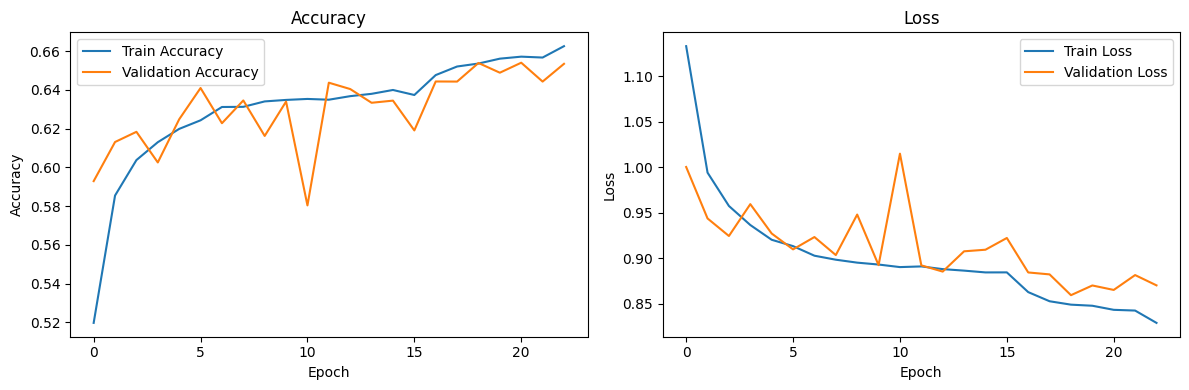

In [51]:
plt.figure(figsize=(12, 4))

# Plot accuracy history
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy * 100:.4f}%")

811/811 [==============================] - 71s 87ms/step - loss: 0.8643 - accuracy: 0.6481
Loss: 0.8642942905426025, Accuracy: 64.8145%


In [48]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

811/811 [==============================] - 70s 86ms/step
Accuracy: 64.81%


In [49]:
print(classification_report(y_test, y_pred, target_names=EVENTS_AASM_NEU))

              precision    recall  f1-score   support

         REM       0.79      0.51      0.62      3253
      NREM 1       0.59      0.71      0.65      8394
      NREM 2       0.60      0.55      0.57      6188
      NREM 3       0.68      0.64      0.66      3910
        Wake       0.74      0.79      0.76      4206

    accuracy                           0.65     25951
   macro avg       0.68      0.64      0.65     25951
weighted avg       0.66      0.65      0.65     25951



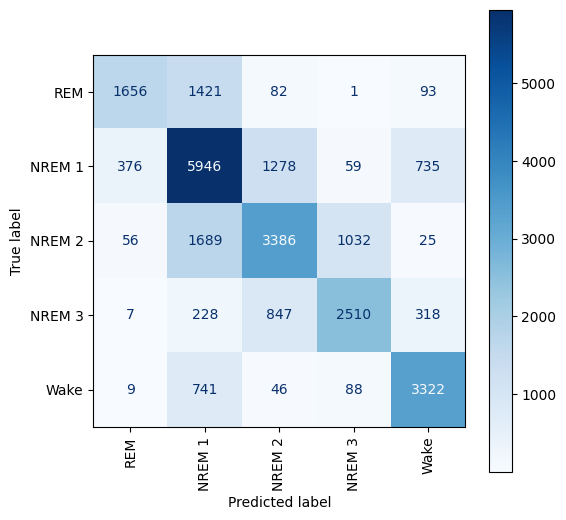

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EVENTS_AASM_NEU.keys())
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues,ax=ax, values_format='d', xticks_rotation=90)
ax.grid(False)
plt.show()